**Table of contents**<a id='toc0_'></a>    
- 1. [Load data           ](#toc1_)    
- 2. [Compute correlation distance         ](#toc2_)    
- 3. [Compute measures for various sets of parameters    ](#toc3_)    
- 4. [Tremor to earthquake energy ratio  ](#toc4_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

In [1]:
# Imports
%matplotlib widget
import numpy as np
import pandas as pd
import pickle

import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba

import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from correlation_measures import cross_corr, correlation_distance, correlation_matrix

# 1. <a id='toc1_'></a>Load data            [&#128285;](#toc0_)

In [2]:
# Tremor data
trm = pd.read_csv('data/nankai/processed/nank_trm_0101_0423.csv', parse_dates=['date'])

In [3]:
# Earthquake data
eq = pd.read_csv('data/nankai/processed/nank_eq_0101_0423.csv', parse_dates=['date'])

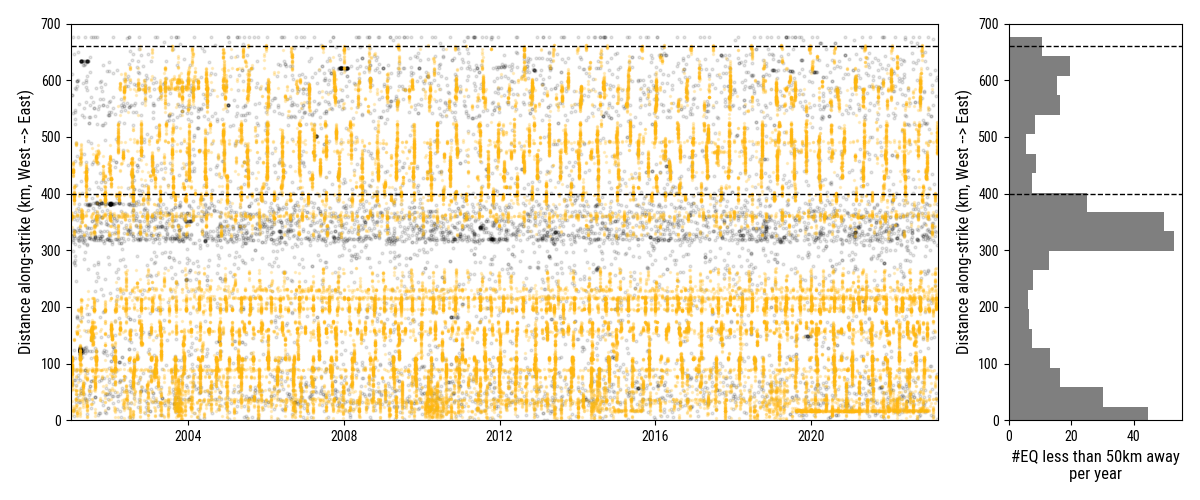

In [4]:
# Overview
fig = plt.figure(figsize=(12, 5))
gs = fig.add_gridspec(1, 2, width_ratios=[1, .2])

dist = 50  # at what distance to consider earthquakes
min_mag = 2.2  # minimum magnitude to consider earthquakes

# Time-strike activity
ax = fig.add_subplot(gs[0, 0])
ax.set_ylabel('Distance along-strike (km, West --> East)')
ax.set_ylim(0, 700)
ax.set_xlim(trm.date.min(), trm.date.max())

ax.plot(trm.date, trm.xf, 'o', ms=1.5, color=to_rgba('C2', .2), label='Tremor')
ax.plot(eq.date[(eq.dist2trm < dist) & (eq.mag > min_mag)], eq.xf[(eq.dist2trm < dist) & (eq.mag > min_mag)], 'o', ms=2, color=to_rgba('k', .1), label='Earthquake', zorder=0)

# Histogram
ax = fig.add_subplot(gs[0, 1])
ax.set_xlabel(f'#EQ less than {dist:d}km away\nper year')
ax.set_ylabel('Distance along-strike (km, West --> East)')
ax.set_ylim(0, 700)

years = (eq.date.max() - eq.date.min()).days / 365
ax.hist(eq.xf[(eq.dist2trm < dist) & (eq.mag > min_mag)], weights=np.ones(len(eq.xf[(eq.dist2trm < dist) & (eq.mag > min_mag)]))/years, bins=20, color='k', alpha=.5, orientation='horizontal', histtype='stepfilled', lw=0)

for ax in fig.axes:
    ax.axhline(400, color='k', lw=1, ls='--')
    ax.axhline(660, color='k', lw=1, ls='--')

plt.tight_layout()
plt.show()

# 2. <a id='toc2_'></a>Compute correlation distance          [&#128285;](#toc0_)

In [5]:
# Parameters for the correlation matrix
# --> Define the spatial bins
dx_bin = 10  # in km, width of bin
xmin_bin = 0
xmax_bin = 700
x_bin_edges = np.arange(xmin_bin, xmax_bin+dx_bin, dx_bin)

# --> Temporal counts
delta = 1  # in days, width of the temporal bin to count tremor events

# --> Parameters for the correlation
norm = True
no_bias = True
look_both_ways = True  # to add the negative lags to the positive

# --> Minimum speed of communication to consider (affects where we look for maximum lag)
v_min = 3.5  # in km/day

cc_mat_parameters = dict(dx_bin=dx_bin, xmin_bin=xmin_bin, xmax_bin=xmax_bin, delta=delta, norm=norm, no_bias=no_bias, look_both_ways=look_both_ways, v_min=v_min)

print('Parameters:\n - dx_bin = {:.0f} km\n  - delta = {:.0f} days\n  - norm = {}\n  - no_bias = {}\n  - look_both_ways = {}\n  - v_min = {:.1f} km/day'.format(dx_bin, delta, norm, no_bias, look_both_ways, v_min))

Parameters:
 - dx_bin = 10 km
  - delta = 1 days
  - norm = True
  - no_bias = True
  - look_both_ways = True
  - v_min = 3.5 km/day


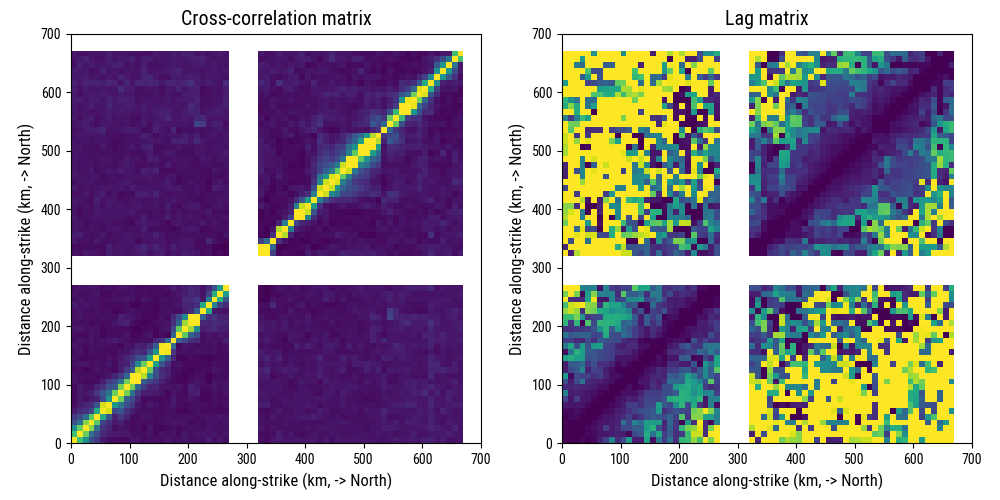

In [6]:
# Compute correlation matrix for this set of parameters
cc_matrix, lag_matrix = correlation_matrix(trm, cc_mat_parameters)

# Show the matrices
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax = axes[0]

cax = ax.imshow(cc_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmax=.5, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> North)')
ax.set_ylabel('Distance along-strike (km, -> North)')
ax.set_title('Cross-correlation matrix')

ax = axes[1]
cax = ax.imshow(lag_matrix, cmap='viridis', extent=[xmin_bin, xmax_bin, xmin_bin, xmax_bin], vmin=0, vmax=50, origin='lower')
ax.set_xlabel('Distance along-strike (km, -> North)')
ax.set_ylabel('Distance along-strike (km, -> North)')
ax.set_title('Lag matrix')

plt.tight_layout()
plt.show()

In [7]:
# Compute correlation distance
cc_thr = 0.07  # threshold defining well-correlated areas

corr_length, left_width, right_width = correlation_distance(cc_matrix, cc_thr, x_bin_edges)

In [8]:
# Compute binned number of felt earthquakes: average number (per year) of earthquakes within given distance of tremor
dists = [10, 20, 30, 50, 100]
min_mags = [1., 1.5, 1.8, 2., 2.2, 2.4]

n_felt_eq = {}
for min_mag in min_mags:
    mag_key = 'm{:.1f}'.format(min_mag)
    n_felt_eq[mag_key] = {}
    for dist in dists:
        dist_key = f'{dist}km'
        n_felt_eq[mag_key][dist_key] = np.zeros(len(x_bin_edges)-1)
        for ii in range(len(x_bin_edges)-1):
            x_min = x_bin_edges[ii]
            x_max = x_bin_edges[ii+1]
            trm_in_bin = trm[trm.xf.between(x_min, x_max)]
            n_felt_eq[mag_key][dist_key][ii] = np.mean(trm_in_bin[f'm{min_mag:.1f}in{dist}km'])

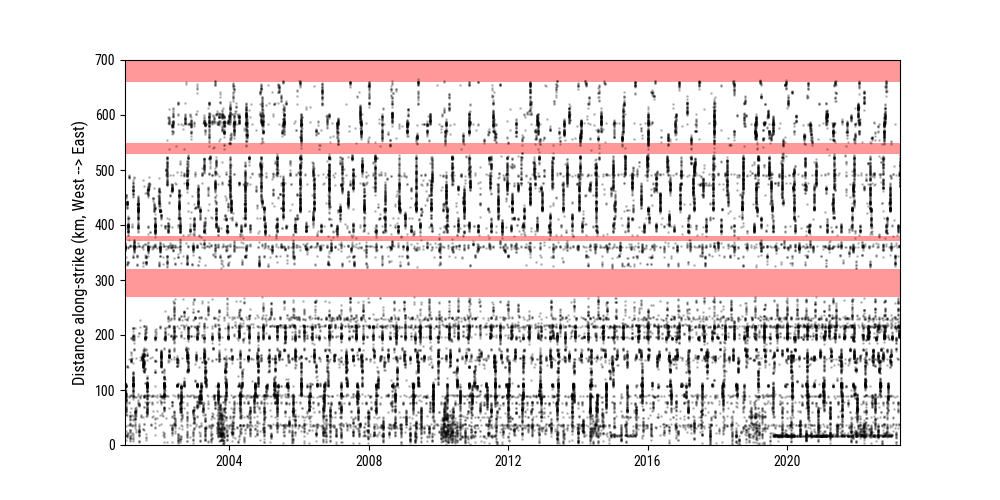

In [9]:
# Compute binned number of tremor
n_tremor, _ = np.histogram(trm.xf, bins=np.arange(xmin_bin, xmax_bin+dx_bin, dx_bin), weights=np.ones(len(trm.xf))/ ((trm.date.max()-trm.date.min())/(365*np.timedelta64(1, 'D'))))
min_n_tremor = 5

# Plot the results
fig, ax = plt.subplots(figsize=(10, 5))
ax.set_xlim(trm.date.min(), trm.date.max())
ax.set_ylim(0, 700)
ax.set_ylabel('Distance along-strike (km, West --> East)')
ax.plot(trm.date, trm.xf, 'o', ms=1, color=to_rgba('k', .2), label='Tremor')
for ii in np.where(n_tremor < min_n_tremor)[0]:
    ax.axhspan(x_bin_edges[ii], x_bin_edges[ii+1], facecolor=to_rgba('r', .4), edgecolor='none', zorder=0)
plt.show()

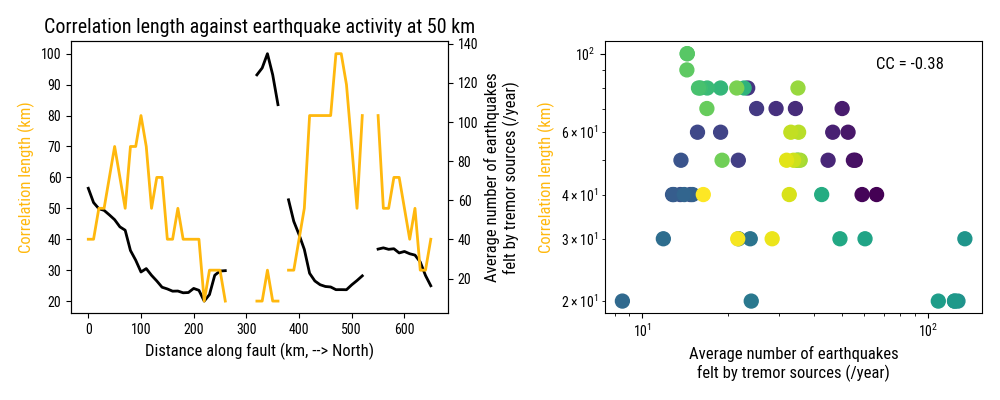

In [10]:
# Against earthquake activity
# --> Compute binned measure of earthquake activity
dists = [10, 20, 30, 50, 100]  # different distances in km

# Plot
dist = 50
min_mag = 2.2
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

corr_length[n_tremor<min_n_tremor] = np.nan
n_felt_eq[f'm{min_mag:.1f}'][f'{dist:d}km'][n_tremor<min_n_tremor] = np.nan

# --> In space
ax = axes[0]
ax.set_title(f'Correlation length against earthquake activity at {dist} km')
ax.set_xlabel('Distance along fault (km, --> North)')
ax.set_ylabel('Correlation length (km)', color='C2')
ax.plot(x_bin_edges[:-1], corr_length, 'C2-', lw=2)

ax_eq = ax.twinx()
ax_eq.set_zorder(-10)
ax.set_facecolor('none')
ax_eq.set_ylabel('Average number of earthquakes\nfelt by tremor sources (/year)', color='k')
ax_eq.plot(x_bin_edges[:-1], n_felt_eq[f'm{min_mag:.1f}'][f'{dist:d}km'], 'k-', lw=2)

# --> One against the other
ax = axes[1]
ax.set_xlabel('Average number of earthquakes\nfelt by tremor sources (/year)')
ax.set_ylabel('Correlation length (km)', color='C2')
sc = ax.scatter(n_felt_eq[f'm{min_mag:.1f}'][f'{dist:d}km'], corr_length, c=x_bin_edges[:-1], cmap='viridis', s=100)
ax.set_xscale('log')
ax.set_yscale('log')

log10_neq = np.log10(n_felt_eq[f'm{min_mag:.1f}'][f'{dist:d}km'][np.isfinite(corr_length) & np.isfinite(n_felt_eq[f'm{min_mag:.1f}'][f'{dist:d}km'])])
log10_cl = np.log10(corr_length[np.isfinite(corr_length) & np.isfinite(n_felt_eq[f'm{min_mag:.1f}'][f'{dist:d}km'])])
cc = np.corrcoef(log10_neq, log10_cl)[0, 1]
ax.text(.9, .9, f'CC = {cc:.2f}', transform=ax.transAxes, ha='right')

plt.tight_layout()
plt.show()

# 3. <a id='toc3_'></a>Compute measures for various sets of parameters     [&#128285;](#toc0_)

In [11]:
# Parameters
cc_thrs = [0.05, 0.07, .1]
dx_bins = [5, 10]
v_mins = [1., 3.5, 10]

In [12]:
# Run through parameters and compute correlation distance (takes time to compute cc_matrix several time)
corr_lengths = {}

for dx_bin in dx_bins:
    dx_key = f'dx{dx_bin:d}km'
    corr_lengths[dx_key] = {}
    for v_min in v_mins:
        v_min_key = f'v{v_min:.1f}kmd'
        corr_lengths[dx_key][v_min_key] = {}

        print('dx_bin', dx_bin, 'v_min', v_min)
        cc_mat_parameters['dx_bin'] = dx_bin
        cc_mat_parameters['v_min'] = v_min

        # Compute correlation matrix
        cc_matrix, lag_matrix = correlation_matrix(trm, cc_mat_parameters)

        x_bin_edges = np.arange(xmin_bin, xmax_bin+dx_bin, dx_bin)

        for cc_thr in cc_thrs:
            print(dx_bin, v_min, cc_thr)

            # Compute correlation distance
            cc_thr_key = f'cc{cc_thr:.2f}'
            corr_lengths[dx_key][v_min_key][cc_thr_key], _, _ = correlation_distance(cc_matrix, cc_thr, x_bin_edges)

dx_bin 5 v_min 1.0
5 1.0 0.05
5 1.0 0.07
5 1.0 0.1
dx_bin 5 v_min 3.5
5 3.5 0.05
5 3.5 0.07
5 3.5 0.1
dx_bin 5 v_min 10
5 10 0.05
5 10 0.07
5 10 0.1
dx_bin 10 v_min 1.0
10 1.0 0.05
10 1.0 0.07
10 1.0 0.1
dx_bin 10 v_min 3.5
10 3.5 0.05
10 3.5 0.07
10 3.5 0.1
dx_bin 10 v_min 10
10 10 0.05
10 10 0.07
10 10 0.1


In [13]:
# Run through bin sizes and compute earthquake count
# Compute binned number of felt earthquakes: average number (per year) of earthquakes within given distance of tremor
dists = [10, 20, 30, 50, 100]
min_mags = [1., 1.5, 1.8, 2., 2.2, 2.4]

n_felt_eqs = {}
for dx_bin in dx_bins:
    dx_bin_key = f'dx{dx_bin:d}km'
    n_felt_eqs[dx_bin_key] = {}
    x_bin_edges = np.arange(xmin_bin, xmax_bin+dx_bin, dx_bin)
    for min_mag in min_mags:
        mag_key = 'm{:.1f}'.format(min_mag)
        n_felt_eqs[dx_bin_key][mag_key] = {}
        for dist in dists:
            dist_key = f'{dist}km'
            n_felt_eqs[dx_bin_key][mag_key][dist_key] = np.zeros(len(x_bin_edges)-1)
            for ii in range(len(x_bin_edges)-1):
                x_min = x_bin_edges[ii]
                x_max = x_bin_edges[ii+1]
                trm_in_bin = trm[trm.xf.between(x_min, x_max)]
                n_felt_eqs[dx_bin_key][mag_key][dist_key][ii] = np.mean(trm_in_bin[f'm{min_mag:.1f}in{dist}km'])

In [14]:
# Run through bin sizes and compute number of tremor in each bin
n_tremors = {}
for dx_bin in dx_bins:
    n_tremors[f'dx{dx_bin:d}km'], _ = np.histogram(trm.xf, bins=np.arange(xmin_bin, xmax_bin+dx_bin, dx_bin), weights=np.ones(len(trm.xf))/ ((trm.date.max()-trm.date.min())/(365*np.timedelta64(1, 'D'))))

In [15]:
# Save results
results_parameters = cc_mat_parameters
results_parameters['dx_bin'] = dx_bins
results_parameters['v_min'] = v_mins
results_parameters['cc_thr'] = cc_thrs
results_parameters['min_mag'] = min_mags
results_parameters['dist'] = dists
results_parameters['min_n_tremor_dx10km'] = 5  # events / per year

results = dict(corr_lengths=corr_lengths, n_felt_eqs=n_felt_eqs, n_tremors=n_tremors, parameters=results_parameters)

path = 'results/nankai/nank2_synch.pkl'
with open(path, 'wb') as f:
    print(f'Saving results to {path}')
    pickle.dump(results, f)

Saving results to results/nankai/nank2_synch.pkl


# 4. <a id='toc4_'></a>Tremor to earthquake energy ratio   [&#128285;](#toc0_)
TODO

In [16]:
# # Compute tremor / earthquake energy ratio
# trm_energy = np.zeros(len(x_bin_edges)-1)
# eq_energy = np.zeros(len(x_bin_edges)-1)
# for ii in range(len(x_bin_edges)-1):
#     trm_energy[ii] = np.sum(trm[trm.xf.between(x_bin_edges[ii], x_bin_edges[ii+1])].energy)
#     eq_in_bin = eq[eq.xf.between(x_bin_edges[ii], x_bin_edges[ii+1])]
#     eq_energy[ii] = np.sum(10**(1.5*eq_in_bin[eq_in_bin.in50km].mag))

# # Plot
# fig, ax = plt.subplots()
# ax.semilogy(x_bin_edges[:-1], trm_energy/eq_energy, 'o-', label='Tremor energy', c='k')
# ax_ = ax.twinx()
# ax_.semilogy(x_bin_edges[:-1], corr_length, 'o-', c='C2', label='Correlation length')
# ax.set_xlabel('Distance along fault (km, --> North)')
# ax.set_ylabel('Tremor to earthquake energy ratio')
# ax_.set_ylabel('Correlation length (km)')
# plt.show()

# fig, ax = plt.subplots()
# ax.loglog(trm_energy/eq_energy, corr_length, 'o', mec='C2', mfc='none', ms=10)
# ax.set_xlabel('Tremor to earthquake energy ratio')
# ax.set_ylabel('Correlation length')
# plt.show()